In [1]:
import os
import sys
import urllib, io

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load dataframe

In [3]:
iterationName = 'pilot4'
read_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df = pd.read_csv(read_path)

### Exclude Outliers

In [4]:
#in progress
#iterationName = 'pilot3'
#read_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
#df3 = pd.read_csv(read_path)

iterationName = 'pilot4'
read_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df = pd.read_csv(read_path)

#df = pd.merge(df3 , df4 , how='outer')

low_scores = df[(df.trialNum == 15) & (df.score == 0)]['gameID']
df = df[~df.gameID.isin(low_scores)]

## Summary Statistics

In [5]:
# Accuracy etc. by condition
df[['condition','normedScore','numBlocks','buildTime']].groupby(by=['condition']).describe()

normedScore                                                   \
                count      mean       std      min       25%       50%   
condition                                                                
mental          256.0  0.717268  0.225641 -0.01675  0.564562  0.766083   
physical        256.0  0.721675  0.228247  0.00000  0.590360  0.764244   

                              numBlocks            ...             buildTime  \
                75%       max     count      mean  ...   75%   max     count   
condition                                          ...                         
mental     0.909644  1.000000     256.0  7.738281  ...  10.0  17.0     256.0   
physical   0.913905  0.994675     256.0  7.691406  ...  10.0  18.0     256.0   

                                                                             \
                   mean           std       min      25%      50%       75%   
condition                                                                     
mental     49908.675781  15950.229810  -82782.0  48007.5  55381.0  57867.25   
physical   46952.375000  34641.218534 -369213.0  43846.0  53802.5  57551.50   

                    
               max  
condition           
mental     60414.0  
physical   64824.0  

[2 rows x 24 columns]

In [6]:
# Accuracy etc. by trial number
df[['condition','normedScore','numBlocks','buildTime','trialNum']].groupby(by='trialNum').describe()

normedScore                                                    \
               count      mean       std       min       25%       50%   
trialNum                                                                 
0               32.0  0.634540  0.222325  0.087363  0.492400  0.678239   
1               32.0  0.665179  0.240216  0.149551  0.505205  0.611214   
2               32.0  0.711787  0.223437  0.224710  0.542481  0.677131   
3               32.0  0.708542  0.179689  0.330376  0.594369  0.746978   
4               32.0  0.691027  0.187108  0.249696  0.566687  0.720855   
5               32.0  0.697204  0.207880  0.002021  0.614421  0.730056   
6               32.0  0.646322  0.284488  0.000000  0.479988  0.666117   
7               32.0  0.760832  0.220029 -0.016750  0.685767  0.806795   
8               32.0  0.729750  0.248041  0.000000  0.582453  0.798227   
9               32.0  0.720758  0.222576  0.192864  0.560096  0.838600   
10              32.0  0.755821  0.211796  0.150126  0.633720  0.776085   
11              32.0  0.745945  0.213316  0.000000  0.626505  0.751422   
12              32.0  0.780088  0.210359  0.350438  0.560320  0.863582   
13              32.0  0.737632  0.237912  0.000000  0.614554  0.764677   
14              32.0  0.765507  0.275231  0.000000  0.702412  0.880958   
15              32.0  0.760610  0.207129  0.203233  0.680011  0.812884   

                             numBlocks           ...              buildTime  \
               75%       max     count     mean  ...    75%   max     count   
trialNum                                         ...                          
0         0.783208  0.976319      32.0  5.84375  ...   8.00  10.0      32.0   
1         0.932088  0.980306      32.0  7.28125  ...   9.00  12.0      32.0   
2         0.935696  0.983443      32.0  6.96875  ...   9.00  11.0      32.0   
3         0.821552  0.975422      32.0  7.65625  ...  10.00  12.0      32.0   
4         0.823006  0.976224      32.0  7.34375  ...  10.00  17.0      32.0   
5         0.848222  0.977855      32.0  8.06250  ...   9.25  13.0      32.0   
6         0.913905  1.000000      32.0  7.84375  ...  10.00  13.0      32.0   
7         0.911080  0.974384      32.0  8.12500  ...  10.00  13.0      32.0   
8         0.930968  0.991952      32.0  7.90625  ...  10.00  14.0      32.0   
9         0.888910  0.979759      32.0  7.84375  ...  10.00  12.0      32.0   
10        0.936863  0.982185      32.0  8.18750  ...   9.00  15.0      32.0   
11        0.937464  0.994675      32.0  7.78125  ...  10.00  14.0      32.0   
12        0.967166  0.992755      32.0  8.03125  ...  10.00  13.0      32.0   
13        0.951994  0.986188      32.0  8.18750  ...  11.00  14.0      32.0   
14        0.939839  0.981629      32.0  7.96875  ...   9.25  18.0      32.0   
15        0.930801  0.987593      32.0  8.40625  ...  10.00  14.0      32.0   

                                                                            \
                 mean           std       min       25%      50%       75%   
trialNum                                                                     
0         51306.59375   9002.645417   19586.0  49448.50  55292.5  56844.50   
1         51869.37500   8219.478979   24960.0  49760.00  54465.0  57399.50   
2         50588.37500  10436.800334   21625.0  45512.50  55910.5  57555.00   
3         54730.25000   6559.427857   24775.0  54072.25  56673.0  57931.75   
4         50194.12500  18045.037881  -40545.0  50597.25  55904.5  58072.25   
5         52157.68750   7677.891686   28039.0  47166.25  54636.0  57699.00   
6         49348.75000  16951.678794  -16912.0  50368.25  56363.5  58214.50   
7         51142.12500   9062.747959   27215.0  48640.75  54795.5  56914.75   
8         44570.75000  26002.883221  -82782.0  41666.25  52443.0  56948.50   
9         51377.40625   9047.098743   30563.0  42613.00  55431.0  57875.50   
10        45898.78125  12734.966278    8337.0  37387.25  49060.0  56945.75   
11      

<Figure size 576x432 with 0 Axes>

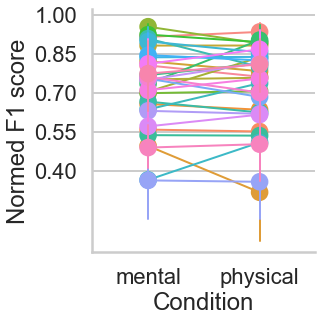

In [7]:
subject_means_by_condition = df.groupby(['gameID','condition']).mean()
condition_means = subject_means_by_condition.groupby('condition')['normedScore'].mean()

subject_scores_by_condition = subject_means_by_condition['normedScore']

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.catplot(x='condition', 
                y='normedScore', 
                hue='gameID', 
                kind='point', 
                legend=False,
                data=df);
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0.4,1,5))
plt.setp(c.ax.lines,linewidth=2)
plt.tight_layout()



In [ ]:
score_condition = df[['condition','normedScore']]

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=score_condition,
                palette='husl',
                hue='condition',
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()


In [ ]:
df['extendedCondition'] = df['condition']
df.loc[(df.condition == 'physical') & (df.numBlocksExplore == 0),'extendedCondition'] = 'no_action_physical'

fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data = df,
                palette='husl',
                hue='extendedCondition',
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()




In [ ]:
df = df[(df.numBlocks>2)]
df = df[~df.gameID.isin(low_scores)]


df['extendedCondition'] = df['condition']
df.loc[(df.condition == 'physical') & (df.numBlocksExplore > 4),'extendedCondition'] = 'very_physical'
df.loc[(df.condition == 'physical') & (df.numBlocksExplore <= 4),'extendedCondition'] = 'not_very_physical'
df.loc[(df.condition == 'physical') & (df.numBlocksExplore == 0),'extendedCondition'] = 'no_action_physical'

fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data = df,
                palette='husl',
                hue='extendedCondition',
                hue_order=['mental','no_action_physical','not_very_physical','physical','very_physical'],
                x='condition',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Condition')
plt.yticks(np.linspace(0,1,6))
plt.tight_layout()




In [ ]:
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data=df,
                palette='husl',
                hue='extendedCondition',
                x='condition',
                y='numBlocks')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('n blocks')
plt.xlabel('condition')
plt.yticks(np.linspace(0,12,6))
plt.tight_layout()

In [ ]:
score_trials = df[['trialNum','normedScore']]

fig = plt.figure(figsize=(8,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.lineplot(data=score_trials,
                palette='husl',
                x='trialNum',
                y='normedScore')
plt.ylabel('Normed F1 score')
plt.xlabel('Trial')
plt.yticks(np.linspace(0.4,1,6))
plt.xticks(np.linspace(0,15,16))
plt.tight_layout()

## Load settled dataframe

In [ ]:
## load in dataframe
iterationName = 'pilot4'

data_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iterationName))
dfs = pd.read_csv(data_path)

### Exclude outliers

In [ ]:
low_scores = df[(df.trialNum == 15) & (df.score == 0)]['gameID']
dfs = dfs[~dfs.gameID.isin(low_scores)]

In [ ]:
# Add a condition for physical with 0 actions
dfs['extendedCondition'] = dfs['condition']

trialInfo = df[['gameID','trialNum','numBlocksExplore']]

dfs = dfs.merge(trialInfo, on=['gameID', 'trialNum'], how='left')

In [ ]:
dfs.loc[(df.condition == 'physical') & (dfs.numBlocksExplore == 0),'extendedCondition'] = 'no_action_physical'

In [ ]:
# Add useful variables to dataframe

dfs['subject_trial'] = dfs['gameID'] + '_' + str(dfs['trialNum'])
dfs['condition_number'] = np.where(dfs['condition']=='mental', 100, 2)
dfs['condition_code'] = dfs['condition_number'] + dfs['trialNum']
dfs['time_bin'] = np.round_(dfs['timePlaced']/10000)*10000

dfs_build = dfs[dfs.phase == 'build']
dfs_explore = dfs[dfs.phase == 'explore']


In [ ]:
dfs['subject_trial'] = dfs['gameID'] + '_' + str(dfs['trialNum'])
dfs['condition_number'] = np.where(dfs['condition']=='mental', 100, 2)
dfs['condition_code'] = dfs['condition_number'] + dfs['trialNum']/2

fig = plt.figure(figsize=(12,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
ax = sns.lineplot(x="timePlaced", 
                  y="normedIncrementalScore", 
                  hue='condition_code', 
                  units="subject_trial",
                  palette='coolwarm',
                  estimator=None, lw=0.7,
                  data=dfs[dfs['phase']=='build'])

#red is mental, blue is physical

In [ ]:
# 'Scores over time across participant and structure, by condition'

fig = plt.figure(figsize=(12,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
ax = sns.lineplot(x="numBlocks", 
                  y="normedIncrementalScore", 
                  hue='extendedCondition', 
                  estimator= np.mean,
                  palette='coolwarm',
                  lw=0.7,
                  data=dfs[dfs.phase == 'build']) #and numblocks=0

In [ ]:
fig = plt.figure(figsize=(12,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
ax = sns.lineplot(x="time_bin", 
                  y="normedIncrementalScore", 
                  hue='extendedCondition', 
                  estimator= np.mean,
                  palette='coolwarm',
                  lw=0.7,
                  data=dfs[dfs.phase == 'build'])

In [ ]:
# 'Mean scores for each structure over time (binned), by condition and phase'

g = sns.FacetGrid(data=dfs, row="targetName", col="phase", height=4, aspect = 2)

sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})

g = g.map_dataframe(sns.lineplot, x="time_bin", 
                  y="normedIncrementalScore", 
                  hue='condition', 
                  estimator= np.mean,
                  palette='coolwarm',
                  lw=0.7).set_titles("{row_name}").add_legend()


In [ ]:
g = sns.FacetGrid(data=dfs, row="targetName", col="phase", height=4, aspect = 2)
sns.set_context('poster')
sns.set_style('whitegrid')
g = g.map_dataframe(sns.lineplot,
                    x="numBlocks", 
                    y="normedIncrementalScore", 
                    hue='condition', 
                    palette='coolwarm',
                    lw=0.7).set_titles("{row_name}").add_legend()


In [ ]:
# 'Individual scores for each attempt at each structure over time, by condition and phase'

g = sns.FacetGrid(data=dfs, row="targetName", col="phase", height=4, aspect = 2, legend_out = True)

sns.set_context('poster')
sns.set_style('whitegrid')
g = g.map_dataframe(sns.lineplot,
                        x="timePlaced", 
                        y="normedIncrementalScore", 
                        hue='condition', 
                        label='condition',
                        units="subject_trial",
                        estimator=None,
                        palette='coolwarm',
                        lw=0.7).set_titles("{row_name}").add_legend()


In [ ]:
# 'Mean scores for each participant over time, by condition and phase'

g = sns.FacetGrid(data=dfs, row="gameID", col="phase", height=4, aspect = 2, legend_out = True)

sns.set_context('poster')
sns.set_style('whitegrid')
g = g.map_dataframe(sns.lineplot,
                        x="time_bin", 
                        y="normedIncrementalScore", 
                        hue='condition', 
                        estimator=np.mean,
                        palette='coolwarm',
                        lw=0.7).set_titles('subject').add_legend()


In [ ]:
# difference?
# more similar at start, at end?

In [ ]:
def iou(x, y):
    
    assert(x.shape == y.shape)
    nblocks = x.shape[0]
    ncols = x.shape[1]

    # find last    
    sum_cols = np.sum(x,axis=0)
    last_block = 0
    while (sum_cols[last_block] > 0):    
        last_block += 1
    
    xt = x[:,0:last_block]
    yt = y[:,0:last_block]
    
    ones = np.ones([nblocks,last_block])
    
    # calculate intersection over union after truncating to length of x
    return  np.sum(xt * yt, axis=None) / np.sum(np.fmin((xt + yt),ones), axis=None)

In [ ]:
max_n_blocks = max(dfs['numBlocks'])
n_block_kinds = dfs['blockKind'].nunique()
blockKinds = np.sort(dfs['blockKind'].unique())
targets = np.sort(dfs['targetName'].unique())

b_map = dict(zip(blockKinds, range(0,n_block_kinds)))
print(b_map)
blockKind_blockNum = np.zeros([n_block_kinds,max_n_blocks])
fig, axs = plt.subplots(len(targets)+1,2, figsize=(12,20))

for ci, condition in enumerate(['mental','physical']):
    p = 0
    for target in targets:
        p += 1
        target_settled = dfs[(dfs.targetName == target) & (dfs.condition == condition) & (dfs.phase == 'build')]

        for i in range(1, max_n_blocks):
            ith_blocks = target_settled[target_settled.numBlocks == i]['blockKind']
            for b in ith_blocks:
                blockKind_blockNum[b_map[b],i] += 1

        #normalize
        blockKind_blockNum = blockKind_blockNum/list(map((lambda x: max([1,x])),np.sum(blockKind_blockNum, axis=0)))

        axs[p,ci].matshow(blockKind_blockNum)        
        axs[p,ci].set_title(target, fontsize=10)

for ax in axs.flat:
    ax.axis('off')

plt.get_cmap().set_bad(color='red')
plt.set_cmap('magma')

In [ ]:
dfs_saved

In [ ]:
max_n_blocks = max(dfs['numBlocks'])
n_block_kinds = dfs['blockKind'].nunique()
blockKinds = np.sort(dfs['blockKind'].unique())
targets = np.sort(dfs['targetName'].unique())
gameIDs = np.sort(dfs['gameID'].unique())

b_map = dict(zip(blockKinds, range(0,n_block_kinds)))
print(b_map)
fig, axs = plt.subplots(len(targets)+1,2, figsize=(12,20))

for ph_i, phase in enumerate(['explore','build']):
    p = 0
    for target in targets:
        blockKind_blockNum = np.zeros([n_block_kinds,max_n_blocks])
        p += 1
        target_settled = dfs[(dfs.targetName == target) &\
                             (dfs.phase == phase) &\
                             (dfs.condition == 'physical')\
                             #(dfs.gameID == gameIDs[1])\
                            ]

        for i in range(1, max_n_blocks):
            ith_blocks = target_settled[target_settled.numBlocks == i]['blockKind']
            for b in ith_blocks:
                blockKind_blockNum[b_map[b],i] += 1

        #normalize
        blockKind_blockNum = blockKind_blockNum/list(map((lambda x: max([1,x])),np.sum(blockKind_blockNum, axis=0)))

        axs[p,ph_i].matshow(blockKind_blockNum)        
        axs[p,ph_i].set_title(target, fontsize=10)

for ax in axs.flat:
    ax.axis('off')

plt.get_cmap().set_bad(color='red')
plt.set_cmap('magma')

In [ ]:
max_n_blocks = max(dfs['numBlocks'])
n_block_kinds = dfs['blockKind'].nunique()
blockKinds = np.sort(dfs['blockKind'].unique())
targets = np.sort(dfs['targetName'].unique())
gameIDs = np.sort(dfs['gameID'].unique())

b_map = dict(zip(blockKinds, range(0,n_block_kinds)))
print(b_map)
fig, axs = plt.subplots(len(targets)+1,2, figsize=(12,20))

for ph_i, phase in enumerate(['explore','build']):
    p = 0
    for target in targets:
        blockKind_blockNum = np.zeros([n_block_kinds,max_n_blocks])
        p += 1
        target_settled = dfs[(dfs.targetName == target) &\
                             (dfs.phase == phase) &\
                             (dfs.gameID == gameIDs[0])]

        for i in range(1, max_n_blocks):
            ith_blocks = target_settled[target_settled.numBlocks == i]['blockKind']
            for b in ith_blocks:
                blockKind_blockNum[b_map[b],i-1] += 1

        #normalize
        blockKind_blockNum = blockKind_blockNum/list(map((lambda x: max([1,x])),np.sum(blockKind_blockNum, axis=0)))

        axs[p,ph_i].matshow(blockKind_blockNum)        
        axs[p,ph_i].set_title(target, fontsize=10)

for ax in axs.flat:
    ax.axis('off')

plt.get_cmap().set_bad(color='red')
plt.set_cmap('magma')

In [ ]:
# 1
#     within-physical, within-structure,  within-participant: final prototype vs. final construction. 
# vs. within-physical, within-structure, between-participant: final prototype vs. final construction. 

# SKIPPED Filter- only final prototypes
# Should also do only final reconstructions

# Make all matrices
# for within participant

max_n_blocks = max(dfs['numBlocks'])
n_block_kinds = dfs['blockKind'].nunique()
blockKinds = np.sort(dfs['blockKind'].unique())
targets = np.sort(dfs['targetName'].unique())
n_targets = dfs['targetName'].nunique()
gameIDs = np.sort(dfs['gameID'].unique())
n_gameIDs = dfs['gameID'].nunique()

b_map = dict(zip(blockKinds, range(0,n_block_kinds)))
seq_mat = np.zeros([n_gameIDs,2,n_targets,n_block_kinds, max_n_blocks])

for gameID_i, gameID in enumerate(gameIDs):
    for ph_i, phase in enumerate(['explore','build']):
        p = 0
        for target_i, target in enumerate(targets):
            blockKind_blockNum = np.zeros([n_block_kinds,max_n_blocks])
            p += 1
            target_settled = dfs[(dfs.targetName == target) &\
                                 (dfs.condition == 'physical')&\
                                 (dfs.phase == phase) &\
                                 (dfs.gameID == gameID)]

            for i in range(0, max_n_blocks-1):
                ith_blocks = target_settled[target_settled.numBlocks == i+1]['blockKind']
                for b in ith_blocks:
                    seq_mat[gameID_i,ph_i,target_i,b_map[b],i] += 1

            #normalize
            seq_mat[gameID_i,ph_i,target_i,:,:] = seq_mat[gameID_i,ph_i,target_i,:,:]/\
                list(map((lambda x: max([1,x])),np.sum(seq_mat[gameID_i,ph_i,target_i,:,:], axis=0)))


# Intersection over union
# If all 1s and 0s: 
# crop to shorter length (or always explore? What if length is 0?)
# (M * N)/(M + N)

# for between participant
# bootstrap- select 1000 random (although we only have a few?)
# Calculating distribution of edit distances
# And find our CI


In [ ]:
# Calculate edit distances between participants with bootstrapping
import random

n_bootstrap = 1000
n_targets = 1

iou_scores = np.zeros([n_targets, n_gameIDs, n_bootstrap])

iter_diff = []

for b in range(0, n_bootstrap-1):
    
    structures_diff = []  
    
    for structure in range(0,16):
        
        #get indices of participants with physical explore sequences of that structure
        built_structure = np.sum(seq_mat[:,1,structure,:,1],axis = 1) > 0
        struct_explore_seqs = seq_mat[built_structure,0,structure,:,:] # grab those sequences
        struct_build_seqs = seq_mat[built_structure,1,structure,:,:] # grab those sequences
    

        num_phys = struct_build_seqs.shape[0]
        
        # calculate observed similarity
        shuff_inds = list(range(0,num_phys-1))
        random.shuffle(shuff_inds)
        
        observed_sim = np.zeros(n_gameIDs)
        permuted_sim = np.zeros(n_gameIDs)
        
        # calculate observed similarity
        for participant in range(0,num_phys-1):
            explore_seq = struct_explore_seqs[participant,:,:]
            build_seq = struct_build_seqs[participant,:,:]
            iou_score = iou(explore_seq, build_seq)
            observed_sim[participant] = iou_score
        
        observed_sim = observed_sim[~pd.isna(observed_sim)]
                                
        for participant in range(0,num_phys-1):
            
            explore_seq = struct_explore_seqs[participant,:,:]
            build_seq = struct_build_seqs[shuff_inds[participant],:,:]
            iou_score = iou(explore_seq, build_seq)
            permuted_sim[participant] = iou_score
            
        permuted_sim = permuted_sim[~pd.isna(permuted_sim)]
                                
        diff_sim = np.mean(observed_sim - permuted_sim)
        structures_diff.append(diff_sim)
    
    iter_diff.append(np.mean(structures_diff))
        
plt.hist(iter_diff)

In [ ]:
np.mean(iter_diff)

In [ ]:
accuracies['gameID'] = gameIDs[0]

In [ ]:
# Calculate edit distance within participants

targets = np.sort(dfs['targetName'].unique())
n_targets = dfs['targetName'].nunique()
gameIDs = np.sort(dfs['gameID'].unique())
n_gameIDs = dfs['gameID'].nunique()

iou_scores2 = np.zeros([n_gameIDs,n_targets])

for participant in range(0,n_gameIDs):

    for structure in range(0,16):
        explore_seq = seq_mat[participant,0,structure,:,:]
        build_seq = seq_mat[participant,1,structure,:,:]
        iou_score = iou(explore_seq,build_seq)
        iou_scores2[participant,structure] = iou_score


In [ ]:
dict(enumerate(targets))

In [ ]:
similarities = pd.DataFrame(iou_scores2[:,:])
similarities = similarities.rename(columns = dict(enumerate(targets)))
similarities['gameID'] = np.sort(dfs['gameID'].unique())
similarities = similarities.melt(id_vars = 'gameID')
similarities = similarities.rename(columns = {'variable': 'targetName',
                                              'value': 'explore_build_similarity'})
similarities

In [ ]:
df = df.merge(similarities, on=['gameID','targetName'], how='left')

In [ ]:
df_saved = df.copy()

In [ ]:
df['sim_group'] = 'None'
df.loc[(df.explore_build_similarity == 1),'sim_group'] = 'total'
df.loc[(df.explore_build_similarity < 1),'sim_group'] = 'low'
df.loc[pd.isna(df.explore_build_similarity),'sim_group'] = 'None'

In [ ]:
df['sim_group'] = 'None'
df.loc[(df.explore_build_similarity == 1),'sim_group'] = 'total'
df.loc[(df.explore_build_similarity < 1),'sim_group'] = 'low'
df.loc[pd.isna(df.explore_build_similarity),'sim_group'] = 'None'

fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data = df[(df.condition=='physical') & (df.sim_group!='None')],
                palette='husl',
                hue='sim_group',
                x='sim_group',
                y='normedScore')
plt.legend(bbox_to_anchor=(1.0,1))
plt.ylabel('Normed F1 score')
plt.xlabel('Similarity between build and explore phase block sequences')


In [ ]:
list(dfs.columns)

In [ ]:
# currently keeping all build attempts that are of same length as maximum explore bout

df1 = dfs[(dfs.condition=='physical') & (dfs.phase=='explore')]
df2 = df1.groupby(by=['trialNum', 'gameID']).count()['numBlocks'].reset_index()
df2 = df2.rename(columns = {'numBlocks':'maxExploreBlocks'})
dfs = dfs.merge(df2, on=['gameID','trialNum'], how = 'left')
#dfs[dfs.numBlocks == dfs.maxExploreBlocks]

In [ ]:
dfs = dfs.merge(similarities, on=['gameID','targetName'], how='left')
dfs['sim_group'] = 'None'
dfs.loc[(dfs.explore_build_similarity == 1),'sim_group'] = 'total'
dfs.loc[(dfs.explore_build_similarity < 1),'sim_group'] = 'low'
dfs.loc[pd.isna(dfs.explore_build_similarity),'sim_group'] = 'None'

In [ ]:
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
b = sns.barplot(data = X3,
                palette='husl',
                hue='sim_group',
                x='phase',
                y='normedIncrementalScore')
plt.ylabel('Normed F1 score')
plt.xlabel('Diff accuracy in build and explore phase up to length of final explore block placed')
#plt.ylim(0.4,0.7)
#plt.yticks(np.linspace(0.4,0.7,5))
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# numBlocks = index in the block sequence
# maxExploreBlocks = number of blocks that were placed in the explore phase
X = dfs
## subset data
X2 = X[(X['condition']=='physical') & (X['maxExploreBlocks']==X['numBlocks'])].reset_index(drop=True)
#X2.drop(labels=['Unnamed: 0', 'Unnamed: 0.1'],axis=1,inplace=True)
X2['trialID'] = X2['gameID'] + '_' + X2['trialNum'].map(str) ## add trialID column
## get list of valid trials for which we have exactly two rows
from collections import Counter
Y = pd.DataFrame.from_dict(Counter(X2['trialID']),orient='index').reset_index()
Y.columns = ['trialID','numAppearances']
valid_num_appearances = Y[Y['numAppearances']==2]['trialID'].values
## get list of trialIDs that have at least one explore and one build phase
Y = X2.groupby('trialID')['phase'].nunique().reset_index()
valid_num_phases = Y[Y['phase']==2]['trialID'].values
valid_trials = np.intersect1d(valid_num_appearances,valid_num_phases)
## further subset to get valid data only
X3 = X2[X2['trialID'].isin(valid_trials)].reset_index(drop=True)
assert np.sum(X3['numBlocks']==0)==0 ## dont consider trials for which no blocks were placed in the explore phase
## pivot to get build & explore scores for each trial
X4 = X3.pivot(index='trialID',columns='phase',values='normedIncrementalScore').reset_index()

In [ ]:
#dfs['trialID'] = dfs['gameID'] + dfs['trialNum'].map(str)
X3

In [ ]:
Y = dfs

In [ ]:
Y = pd.DataFrame.from_dict(Counter(X2['trialID']),orient='index').reset_index()
Y.columns = ['trialID','numAppearances']
valid_num_appearances = Y[Y['numAppearances']==2]['trialID'].values
## get list of trialIDs that have at least one explore and one build phase
Y = X2.groupby('trialID')['phase'].nunique().reset_index()
valid_num_phases = Y[Y['phase']==2]['trialID'].values
valid_trials = np.intersect1d(valid_num_appearances,valid_num_phases)
## further subset to get valid data only
X3 = X2[X2['trialID'].isin(valid_trials)].reset_index(drop=True)
assert np.sum(X3['numBlocks']==0)==0 ## dont consider trials for which no blocks were placed in the explore phase
## pivot to get build & explore scores for each trial
X4 = X3.pivot(index='trialID',columns='phase',values='normedIncrementalScore').reset_index()

In [ ]:

## save out to csv dir, where all the csv's go to live
out_path = os.path.join(csv_dir,'similarity_settled_block_silhouette_{}.csv'.format(iterationName))
dfs.to_csv(out_path)

In [ ]:
dfs[dfs.condition=='physical']

In [ ]:

mean_similarities = np.mean(similarities,axis=1)
plt.hist(mean_similarities[~pd.isna(mean_similarities)])

In [ ]:
all_sim = iou_scores2.reshape(-1)
plt.hist(all_sim[~pd.isna(all_sim)])

In [ ]:
# demo

participant = 0

fig, axs = plt.subplots(len(targets)+1,2, figsize=(12,20))

iou_scores = []

for structure in range(0,16):
    explore_seq = seq_mat[participant,0,structure,:,:]
    build_seq = seq_mat[participant,1,structure,:,:]
    axs[structure,0].matshow(explore_seq)
    axs[structure,1].matshow(build_seq)
    iou_score = iou(explore_seq,build_seq)
    iou_scores.append(iou_score)

for ax in axs.flat:
    ax.axis('off')

plt.get_cmap().set_bad(color='red')
plt.set_cmap('magma')

print(iou_scores)

In [ ]:
participant = 0

fig, axs = plt.subplots(len(targets)+1,2, figsize=(12,20))

for phase in [0,1]:
    for structure in range(0,16):
        axs[structure,phase].matshow(seq_mat[participant,phase,structure,:,:])        

for ax in axs.flat:
    ax.axis('off')

plt.get_cmap().set_bad(color='red')
plt.set_cmap('magma')

In [ ]:
# 2
# within-structure, between-conditions, between-participants : final physical constructions vs. final mental constructions


In [ ]:
#code that turned out not to be useful but keeping for reference if I want to do similar analyses

dfsmat = dfs[['gameID','blockKind','numBlocks','targetName','condition']]
dfsmatCounts = dfsmat.groupby(['condition','targetName','numBlocks','blockKind']).count()['gameID']
dfsmatTotals = dfsmat.groupby(['condition','targetName','numBlocks']).count()['blockKind']
dfsmatNormed = dfsmatCounts/dfsmatTotals
dfsmatNormed = dfsmatNormed.reset_index()

g = sns.FacetGrid(data=dfsmatNormed.unstack(level=0), 
                           row="targetName", col="condition", height=4, aspect = 2, legend_out = True)

sns.set_context('poster')
sns.set_style('whitegrid')
g = g.map_dataframe(sns.heatmap, 
                        vmin = 0,
                        vmax = 1,
                        palette='coolwarm').set_titles("{targetName}")


In [ ]:
dfsmat = dfs[['gameID','blockKind','numBlocks','targetName','condition']]
dfsmatCounts = dfsmat.groupby(['condition','targetName','numBlocks','blockKind']).count()['gameID']
dfsmatTotals = dfsmat.groupby(['condition','targetName','numBlocks']).count()['blockKind']
dfsmatNormed = dfsmatCounts/dfsmatTotals